# KNN Classification Analysis of Stroke Prediction 

In [ ]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
install.packages("themis")
library(themis)

set.seed(2023)
options(repr.matrix.max.rows = 8) 

## Introduction

"insert introduction"

## <br> Cleaning & Wrangling the Data

First, the data set was uploaded onto Google Drive and read into R using the URL link.


In [ ]:
brainstroke_data <- read_csv("https://drive.google.com/uc?export=download&id=1yBiO_qBE9_YBvnEyPe2bazH5ZCOBb1d6")

##### Table 1. Stroke Data Set Preview

In [38]:
brainstroke_data

gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Male,40,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
Female,45,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
Male,40,0,0,Yes,Private,Rural,83.94,30.0,smokes,0
Female,80,1,0,Yes,Private,Urban,83.75,29.1,never smoked,0


<br> As shown from table 1, the data set contains variables such as marriage status (ever_married) that intuitively won't be relevant in predicting stroke because it is not a known risk factor so it is taken out. The target variable (stroke) is in "chr" format so it was changed to factor ("fct") so that we can compute functions more easily later. The BMI variable was renamed so that it is more clear what the acronym stands for. <b> Note that in the stroke variable, 0 corresponds to no stroke observations and 1 corresponds to have had a stroke. 


In [39]:
#changed chr to fct, then got rid of ever_married
brainstroke_data_v1 <- brainstroke_data |> 
    mutate(across(c(gender, hypertension:Residence_type, smoking_status:stroke),
                  as_factor)) |>
    select(1:4, 6:11)

#renamed BMI column
colnames(brainstroke_data_v1)[8] <- 'body_mass_index'

##### Table 2. Cleaned Stroke Data Set 

In [40]:
brainstroke_data_v1

gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,body_mass_index,smoking_status,stroke
<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
Male,67,0,1,Private,Urban,228.69,36.6,formerly smoked,1
Male,80,0,1,Private,Rural,105.92,32.5,never smoked,1
Female,49,0,0,Private,Urban,171.23,34.4,smokes,1
Female,79,1,0,Self-employed,Rural,174.12,24.0,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Male,40,0,0,Private,Urban,191.15,31.1,smokes,0
Female,45,1,0,Govt_job,Rural,95.02,31.8,smokes,0
Male,40,0,0,Private,Rural,83.94,30.0,smokes,0
Female,80,1,0,Private,Urban,83.75,29.1,never smoked,0


<br> Next, we checked for missing data so that we can exclude those observations in our data analysis. Luckily, the data set does not include any missing data as shown in table 3. 

In [41]:
not_available <- brainstroke_data_v1 |>
    summarize(across(everything(), ~ sum(is.na(.))))

##### Table 3. Missing Data 

In [42]:
not_available

gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,body_mass_index,smoking_status,stroke
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0


<br> The first summary performed was calculating the proportions of the class labels in the stroke variable to check if the classes are balanced. As shown in table 4, 4733 observations did not get a stroke versus 248 observations that did get a stroke. The ratio of observations in stroke is about 1:20 which is extremely imbalanced. This is very likely to cause problems in KNN classification because the algorithm is based on majority vote. Thus, we will attempt to fix this in the data analysis section. 

In [43]:
total_obs <- nrow(brainstroke_data_v1)

stroke_proportions <- brainstroke_data_v1 |>
    group_by(stroke) |>
    summarize(stroke_count = n(),
              percentage = round((stroke_count / total_obs) * 100, 2))

##### Table 4. Proportion of Observations +/- Stroke 

In [44]:
stroke_proportions

stroke,stroke_count,percentage
<fct>,<int>,<dbl>
0,4733,95.02
1,248,4.98


## <br> Selecting Predictor Variables 

The training data will be used to train our classifier and the testing data will be used to evaluate the accuracy of our classifier.  We chose to do a 75% to 25% training data to testing data split because we wanted to use more data to train for a more accurate model. The strata argument is set to the stroke variable so that there is an equal proportion of observations in each class that is assigned to each data set, so that they are representative of the original data set. Lastly, the analysis will be done with randomness via seeds (set at the top of the report) so that the data is still reproducible. 


In [45]:
brainstroke_split <- initial_split(brainstroke_data_v1, prop = 0.75, strata = stroke)

brainstroke_training <- training(brainstroke_split)
brainstroke_testing <- testing(brainstroke_split)

<br> To see if there was a pattern in the potential predictor variables, the average BMI, glucose level, and age of those with or without stroke was computed. As shown in table 5, there are differences between the mean values of all three variables, notably  glucose level and age. This is expected as they have been recognized as risk factors for stroke in numerous studies (Diabetes, 2022). Thus, this indicates that these variables may be good predictors for stroke. 

In [46]:
stroke_bmi_gluc_age_avg <- brainstroke_training |>
    group_by(stroke) |>
    summarise(avg_bmi = round(mean(body_mass_index), 2),
              avg_glucose = round(mean(avg_glucose_level), 2),
              avg_age = round(mean(age), 2))

##### Table 5. Average BMI, Glucose Level, and Age Separated by Stroke Condition 

In [47]:
stroke_bmi_gluc_age_avg

stroke,avg_bmi,avg_glucose,avg_age
<fct>,<dbl>,<dbl>,<dbl>
0,28.40,104.73,42.30
1,30.27,131.80,68.09


<br> To confirm whether the three aforementioned variables will be good predictors, we compared how it interacts with the stroke condition using visualizations. Figure 1 shows the histogram for the distribution of age distinguished in colour by the stroke condition. It indicates that people who have had a stroke tend to be older whereas people who don’t have a stroke are of all ages. As we do see a trend in the stroke condition and from the result of the summary statistic above, this variable will likely be a good predictor so it will be used in the classification. 


In [48]:
histogram_data <- brainstroke_training |>
    mutate(stroke = recode(stroke, '0' = "No", '1' = "Yes"))
    
age_histogram_plot <- histogram_data |>
    ggplot(aes(x = age, fill = stroke)) +
    geom_histogram(bins = 15) +
    xlab("Age of Individual (Years)") +
    ylab("Number of Individuals") +
    labs(fill = "Has had a Stroke") +
    ggtitle("Distribution of Population Age") +
    theme(text = element_text(size=15))

##### Figure 1. Histogram of Population Age across Stroke Condition

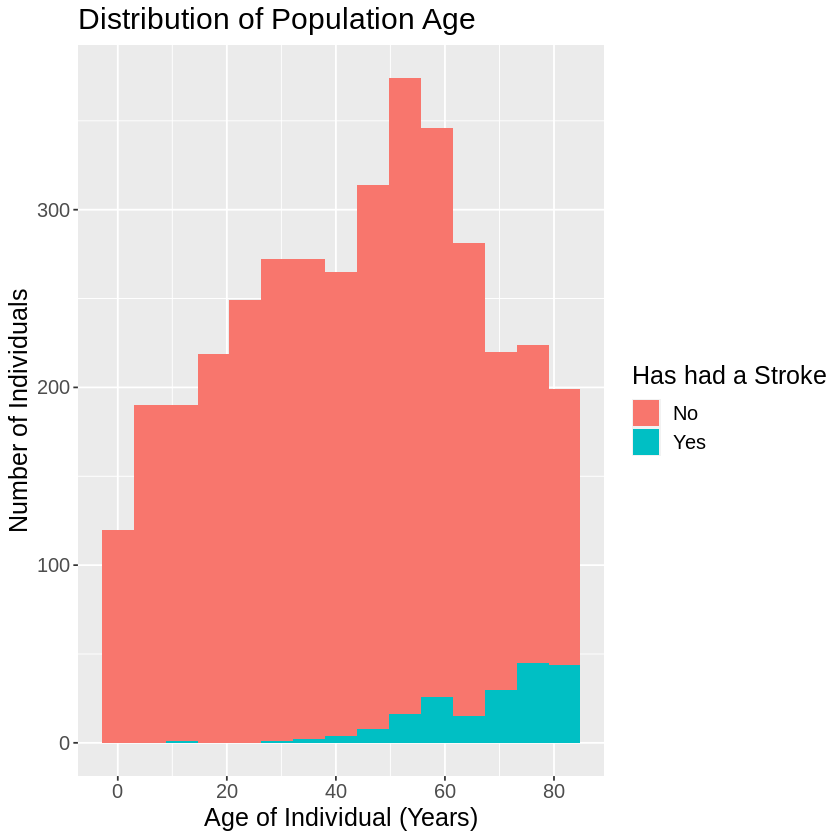

In [49]:
age_histogram_plot

<br> Next, for the distribution of BMI as shown in figure 2, there is no prominent trend for how BMI may affect the chances of getting a stroke as most of the observations that have had a stroke are across most BMI values. Thus, from the results of the summary statistic and figure 2, BMI is likely not a good predictor so it will not be used in the classification. 


In [50]:
bmi_histogram_plot <- histogram_data |>
    ggplot(aes(x = body_mass_index, fill = stroke)) +
    geom_histogram(bins = 25) +
    xlab("BMI of Individual (kg/m^2)") +
    ylab("Number of Individuals") +
    labs(fill = "Has had a Stroke") +
    ggtitle("Distribution of Population BMI") +
    theme(text = element_text(size=15))

##### Figure 2. Histogram of Body Mass Index (BMI) across Stroke Condition

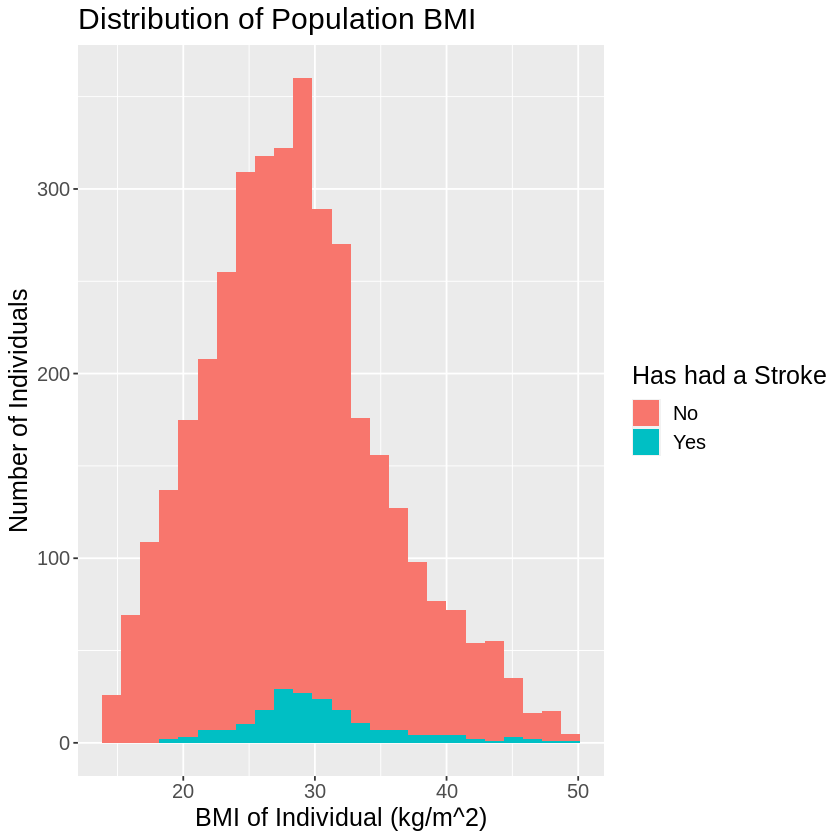

In [51]:
bmi_histogram_plot

<br>Finally, we compared the distribution of glucose levels in figure 3. The values for those who have had a stroke gather outside of the safe zone of 120-180 (Diabetes, 2022); they are at very low or high glucose levels. This trend is present in the no-stroke condition as well. However, considering the summary statistic, the observations that got a stroke have a much higher average glucose level compared to the observations that did not get a stroke. In addition to previous studies that have indicated high glucose levels as a risk factor for stroke, this variable may still be an important predictor so it will be used in the classification. 

In [52]:
glucose_histogram_plot <- histogram_data |>
    ggplot(aes(x = avg_glucose_level, fill = stroke)) +
    geom_histogram(bins = 15) +
    xlab("Glucose Level (mg/dL)") +
    ylab("Number of Individuals") +
    labs(fill = "Has had a Stroke") +
    ggtitle("Distribution of Population Glucose Levels") +
    theme(text = element_text(size=15))

##### Figure 3. Histogram of Glucose Level across Stroke Condition

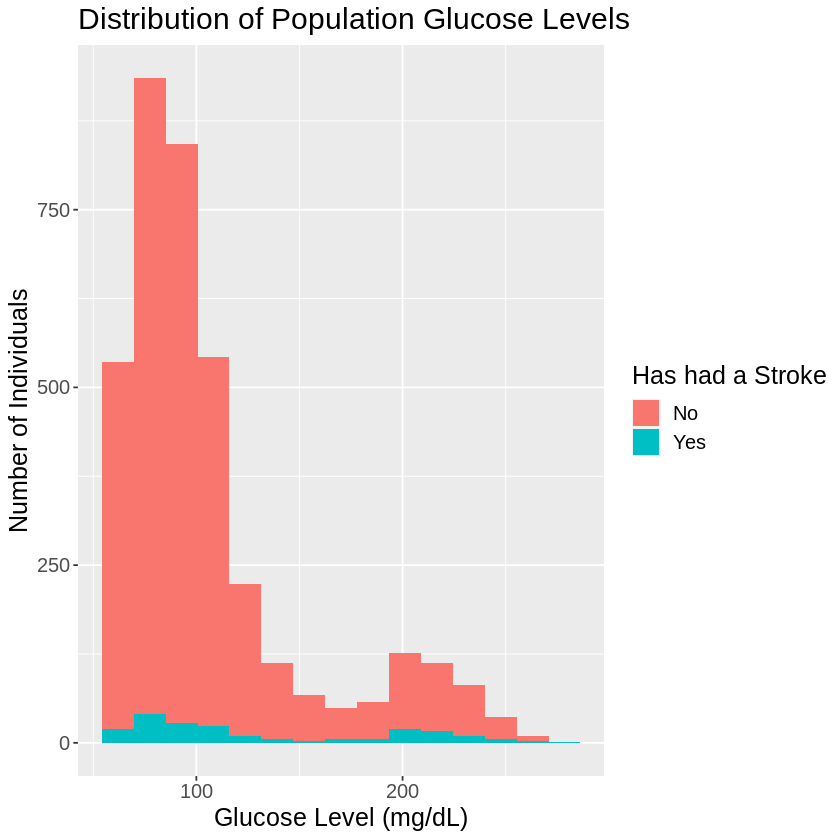

In [53]:
glucose_histogram_plot

##### Table 6. Average Glucose Level Separated by Stroke Condition 

In [54]:
select(stroke_bmi_gluc_age_avg, stroke, avg_glucose)

stroke,avg_glucose
<fct>,<dbl>
0,104.73
1,131.80


<br> Note: The categorical variables were not summarized because only the numerical variables were of interest since there is no distance to calculate between points with categorical variables. Thus, we can't use them in our classification algorithm explained below. 


## <br> Data Analysis
Classification will be performed using the K-nearest-neighbor (KNN) algorithm. The target variable is the “stroke” column. As determined with the summary statistics and visualizations above, the predictor variables are <b> age and glucose levels. 

To resolve the problem of class imbalance, we oversampled the rare class (the group that got a stroke) so that this group has more voting power in the KNN algorithm. We chose to standardize the data because multiple numerical variables are used and they are on different scales (glucose levels are higher than age values) which will affect how the KNN algorithm calculates the nearest distance.  

In [55]:
brainstroke_recipe_balanced <- 
    recipe(stroke ~ age + avg_glucose_level, data = brainstroke_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_upsample(stroke, over_ratio = 1, skip = FALSE) 

brainstroke_recipe_balanced

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Centering for all_predictors()
Scaling for all_predictors()
Up-sampling based on stroke

In [56]:
#code for balanced data  
balanced_stroke <- brainstroke_recipe_balanced |>
prep() |>
bake(brainstroke_training)
balanced_stroke

age,avg_glucose_level,stroke
<dbl>,<dbl>,<fct>
-1.7984685,-0.2426786,0
0.6361484,-0.4005919,0
-1.5771397,0.1051277,0
1.1673376,-0.8178713,0
⋮,⋮,⋮
1.4771979,0.3971350,1
1.6985267,2.0025137,1
1.2116033,-0.5373325,1
0.6361484,-0.7702326,1


<br> As shown, the classes are now more balanced. However, there may be the issue of overfitting the model to the data because it increases the number of observations in the class that does have a stroke. Thus, cross-validation may not work as well and this should be noted for future research to use a more balanced dataset. 

##### Table 8. Confirmation of Balanced Data 

In [57]:
#table output
balanced_stroke |>
  group_by(stroke) |>
  summarize(count = n())

stroke,count
<fct>,<int>
0,3543
1,3543


<br> To tune our model, cross-validation was performed to choose the best K value. A dummy recipe had to be made to work around the cross-validation function because of upsampling. 

In [58]:
#dummy recipe to input for cross-validation
dummy_recipe <- recipe(stroke ~ age + avg_glucose_level, data = balanced_stroke)

#5-fold cross-validation on training set, if I use the balanced_stroke dataset, K=1
brainstroke_vfold <- vfold_cv(brainstroke_training, v = 5, strata = stroke)

#KNN classifier
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

#K values to test
gridvals = tibble(neighbors = seq(1, 51, by = 5))


knn_results <- workflow() |>
       add_recipe(dummy_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = brainstroke_vfold, grid = gridvals) |>
       collect_metrics()

##### Table 8. Cross-validation best K results

In [59]:
accuracies <- knn_results |> 
       filter(.metric == "accuracy") 

#to see which K has the highest accuracy estimate
best_accuracies <- accuracies |>
arrange(desc(mean)) |>
slice(1)

best_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
16,accuracy,binary,0.9485944,5,0.002012489,Preprocessor1_Model04


<br> Then, a scatter plot was made to pick a K value that has a high accuracy estimate but also does not change its accuracy by much when we increase or decrease K to a nearby value. The K that fits this criterion is K= 16 with an accuracy of approximately 0.95. 

In [60]:
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 51, by = 5)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.65, 1.00)) + # adjusting the y-axis 
       theme(text = element_text(size = 20))

##### Figure 4. Scatter Plot of K Neighbours VS Accuracy Estimate

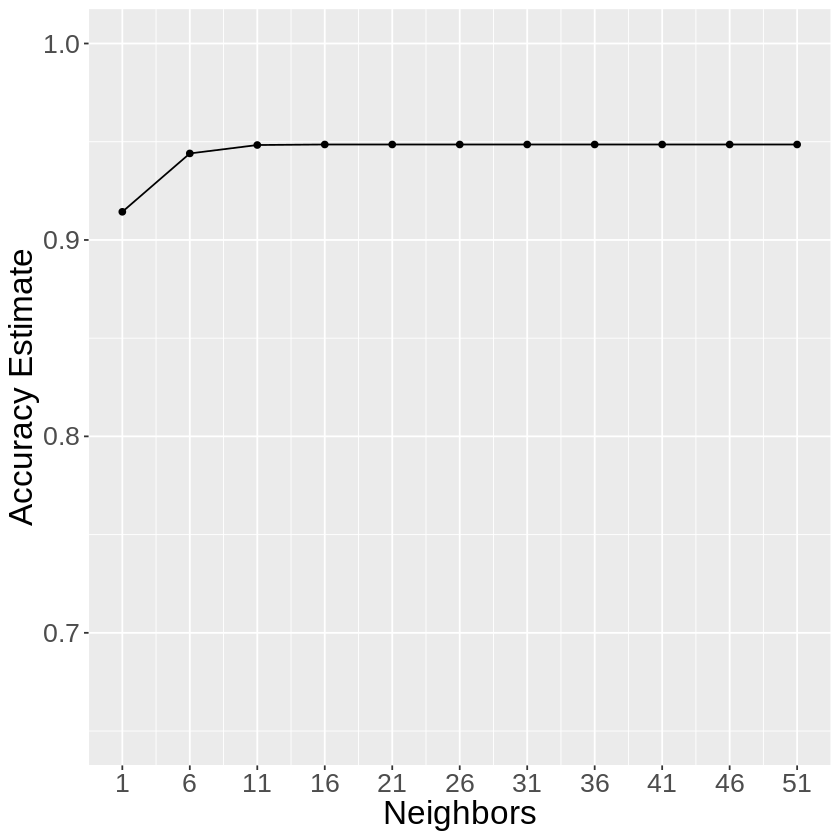

In [61]:
accuracy_versus_k

<br> Then, we retrained the model with K=16 to build our classifier. 

In [62]:
knn_spec_accurate <- nearest_neighbor(weight_func = "rectangular", neighbors = 16) |>
       set_engine("kknn") |>
       set_mode("classification")

#No workflow was used to avoid applying the upsample function to the testing data later
brainstroke_fit <- knn_spec_accurate |>
fit(stroke ~ age + avg_glucose_level, data = balanced_stroke)

brainstroke_fit

parsnip model object


Call:
kknn::train.kknn(formula = stroke ~ age + avg_glucose_level,     data = data, ks = min_rows(16, data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1265876
Best kernel: rectangular
Best k: 16

<br> The testing data has to be standardized manually to calculate for the nearest neighbour on the same scale as the training data model. Finally, we tested the classifier on the testing data to determine its accuracy.


In [63]:
scaled_brainstroke_testing <- recipe(stroke ~ age + avg_glucose_level, data = brainstroke_training) |>
step_scale(all_predictors()) |>
step_center(all_predictors()) |>
prep() |>
bake(brainstroke_testing)

brainstroke_test_predictions <- predict(brainstroke_fit, scaled_brainstroke_testing) |>
       bind_cols(scaled_brainstroke_testing)
brainstroke_test_predictions 

brainstroke_prediction_accuracy <- brainstroke_test_predictions |>
         metrics(truth = stroke, estimate = .pred_class) |>
         filter(.metric == "accuracy")

.pred_class,age,avg_glucose_level,stroke
<fct>,<dbl>,<dbl>,<fct>
1,1.344401,-0.7947136,1
1,1.521464,-1.0487865,1
1,1.565729,2.3811969,1
1,0.901743,1.8854020,1
⋮,⋮,⋮,⋮
1,-0.5147614,-0.6989952,0
0,-1.1787478,-0.2900967,0
0,-1.1344821,-0.1103490,0
0,-0.1606353,1.8752567,0


<br> As shown in table 9, the prediction accuracy was found to be approximately 0.78. 

##### Table 9. Prediction Accuracy on Testing Data

In [47]:
brainstroke_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.776886


<br> The confusion matrix was also computed to see the predictions and any false negative or positives. 


In [48]:
confusion <- brainstroke_test_predictions |>
             conf_mat(truth = stroke, estimate = .pred_class)

##### Table 10. Confusion Matrix

In [49]:
confusion

          Truth
Prediction   0   1
         0 925  25
         1 253  43

<br> To model the classifier's accuracy, the result was visualized with a scatter plot using the predictor variables. Training data was coloured by stroke condition and the diagnosis of a random observation from the testing data was labelled in a different colour so that we can see where the classifier was making its choice. Accuracy was visualized by colouring the area where the classifier makes the classification. The classifier would be most accurate when the real class of the data point matches the colour of the plot background.
 

In [32]:
#code for scatter plot
age_grid <- seq(min(balanced_stroke$age), 
                max(balanced_stroke$age), 
                length.out = 100)
glu_grid <- seq(min(balanced_stroke$avg_glucose_level), 
                max(balanced_stroke$avg_glucose_level), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(age = age_grid, 
                                avg_glucose_level = glu_grid))

StrokePredGrid <- predict(brainstroke_fit, asgrid)

prediction_table <- bind_cols(StrokePredGrid, asgrid) |> 
rename(stroke = .pred_class)

filter(prediction_table, stroke == 1)

wkflw_plot <- ggplot() +
  geom_point(data = balanced_stroke, 
             mapping = aes(x = age, y = avg_glucose_level, color = stroke), size = 2) + 
  geom_point(data = prediction_table, mapping = aes(x = age, 
             y = avg_glucose_level, 
             color = stroke), 
             alpha = 0.02, size = 5) +
  labs(color = "Diagnosis", 
       x = "Age (years, standardized)", 
       y = "Average Glucose Level (mg/dL, standardized)") +
  scale_color_manual(labels = c("No Stroke", "Stroke"), 
                     values = c("lightsalmon", "cornflowerblue")) +
  theme(text = element_text(size = 20))

stroke,age,avg_glucose_level
<fct>,<dbl>,<dbl>
1,-1.419665,-1.131021
1,-1.383124,-1.131021
1,-1.346583,-1.131021
1,-1.310042,-1.131021
⋮,⋮,⋮
1,1.576685,3.677328
1,1.613226,3.677328
1,1.649766,3.677328
1,1.686307,3.677328


##### Figure 5. Scatter Plot of KNN Classifier Prediction Accuracy

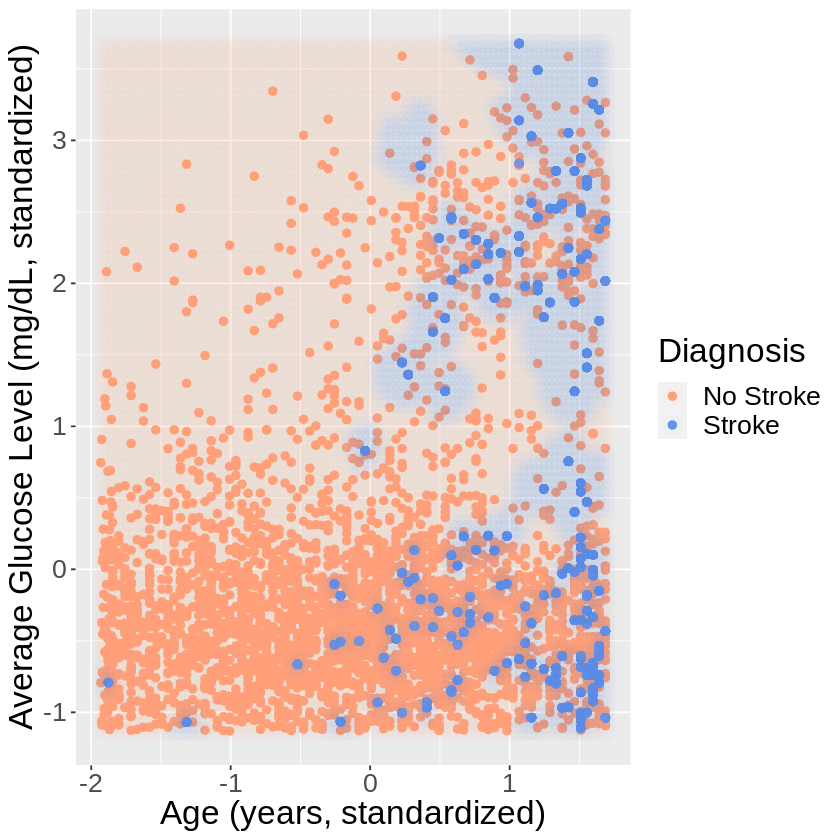

In [33]:
wkflw_plot

<br> To further assess the classifier's predictive capacity, a scatter plot to visualize the wrong predictions was produced. 

In [34]:
#filter for wrong predictions
wrong_data <- brainstroke_test_predictions |>
filter(.pred_class !=stroke)

#filter for correct predictions
correct_data <- brainstroke_test_predictions |>
filter(.pred_class == stroke)

wrong_plot <- ggplot() + 
geom_point(data = correct_data, aes(x = age, y = avg_glucose_level, color = stroke)) + 
geom_point(data = wrong_data, aes(x =age, y = avg_glucose_level), color = "black") +
labs(color = "Correct Predictions", x = "Age (years, standardized)", y = "Average Glucose Level (mg/dL, standardized)") +
scale_color_manual(labels = c("No Stroke", "Stroke"), 
                     values = c("lightsalmon", "cornflowerblue")) +
theme(text = element_text(size = 20)) 

##### Figure 6. Scatter Plot Indicating Wrong Predictions in Black

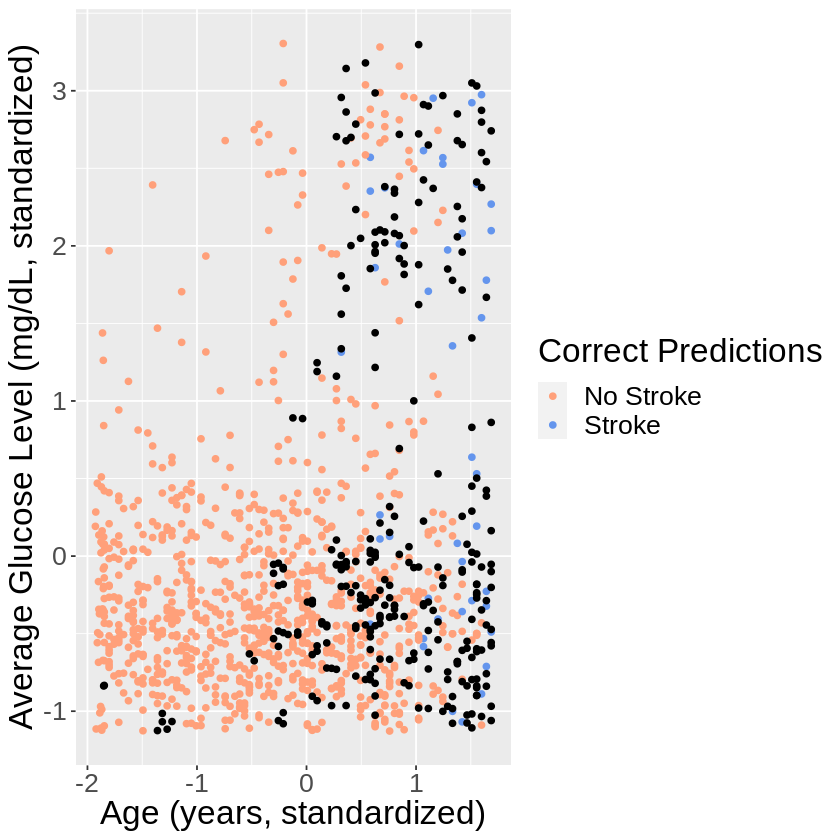

In [35]:
wrong_plot

## <br> Discussion 

The analysis shows that our model predicted a patient from our traing data's stroke status using their age and blood glucose level at an accuracy of 0.74 (Table 9). This is lower than the accuracy estimate from cross-validation of 0.95 (Table 8). There were 253 cases of false positives (non-stroke classified as stroke) at a rate of 0.215 and 25 false negatives at a rate of 0.367. Visually, the region classified as stroke is located towards the higher end of both age and blood glucose level.

Our findings coincide with our expectations that age and blood glucose level are good indicators for whether a person has suffered a stroke before. If an individual is older and has a high blood glucose level, they are likely to have had a prior brain stroke. 

The results show that age and blood glucose levels may be contributors to the likelyhood of an individual having suffered from a stroke. This means that for those who fall under the area where they are predicted to have had a stroke, but have not had one yet (false positives), they may be likely to suffer from a stroke later in life. In our model, we are only classifying those who have already had a stroke, which is a severe medical issue which requires immediate medical attention and will likely not go unnoticed. This means that we would like to be able to classify those who haven't had a stroke yet, but are at high-risk of getting a stroke. However, our data only covers a single point in time, therefore, we have no way of knowing accurately if those predicted to have suffered a stroke, but have not had one yet, will suffer from a stroke at some point in their lives and the timeframe for when that would occur.  Despite the limitation of our data, age and blood glucose level have both been shown to be related to patients who have suffered from a stroke. For those who are mindful of their health, or for those who fall under the area where having suffered from a stroke is likely, monitoring blood glucose level could be a benefit to preventing a brain stroke.

A future question that naturally comes up, having outlined the potential limitations of our model, would be to classify the likelyhood of someone who hasn't had a stroke yet to suffer from a stroke within the next year given relevant predictors about their health. This could also classify the likelyhood for someone who has already suffered from a stroke to get another one within the next year. This would allow preventative measures to be taken for those classified as being likely to suffer from a stroke, and could help guide medical professionals in their treatments and practices for preventing brain strokes.


## <br> References